# Initial Exploration of FIFI Data

This notebook provides an introduction to the `Find it, Fix it` data.  

------------  

In [1]:
import warnings; warnings.simplefilter('ignore')

import datetime as dt
import re
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 600)
# pd.set_option('precision', 3)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# read pickle file into a pandas dataframe:
df = pd.read_pickle("data/fifi_data_2013-19.pkl", compression='infer')
print("Initial FIFI df has \033[1m{:,} rows and {:,} columns\033[0m\n".format(df.shape[0],
                                                                              df.shape[1]))
df["FIFI_category"].replace({"Abnd_Vehicle": "Abandoned_Vehicle",
                             "Needles/Dumping": "Garbage"}, inplace=True)

# remove any columns that are more than half empty 
th = np.round(0.5*df.shape[0], 0)
df.dropna(axis=1, thresh=th, inplace=True) # 150000

print("\nModified FIFI df has \033[1m{:,} rows and {:,} columns\033[0m\n".format(df.shape[0],
                                                                                 df.shape[1]))
df.head(3)

Initial FIFI df has 248,815 rows and 67 columns


Modified FIFI df has 248,815 rows and 44 columns



,Service_Request_Number,Created_Date,Location,Location_Details,Description,Photo,FIFI_category,date,year,month,day,day_of_week,hour,zip,neighborhood,SittingInformal,Lying,DisruptiveActivity_Aggressive,DisruptiveActivity_Intoxicated,LivingActivities,Soliciting,overdose,pop,pop_dens,housing_units,med_home,land_area,occupied_units,occupied_ratio,med_income,med_age,male_%,white_%,fam_%,nokid_%,mortgage_%,fulltime_%,unemploy,drive_%,publictrans_%,other_%,wrk_travel,city council,county council
0,13-00036779,2013-05-09 20:32:33,"5208 BEACON AVE S, SEATTLE, WA","5200 Beacon Ave S Seattle, WA 98108; XY: 12775...",Ford light blue,NaN,Abandoned_Vehicle,2013-05-09,2013,5,9,Thursday,20,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13-00064098,2013-08-13 18:05:17,"2629 SW ANDOVER ST, SEATTLE, WA","26012799 SW Andover St, Seattle; XY: 1261975.9...",NaN,http://servicerequest.seattle.gov/media/seattl...,Abandoned_Vehicle,2013-08-13,2013,8,13,Tuesday,18,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13-00064109,2013-08-13 18:57:44,"402 BELMONT AVE E, SEATTLE, WA","327 Belmont Ave E, Seattle; XY: 1272796.132329...",I don't think this car has been moved in quite...,http://servicerequest.seattle.gov/media/seattl...,Abandoned_Vehicle,2013-08-13,2013,8,13,Tuesday,18,WA,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Strange Data Values

While the data in many columns looks as expected, _e.g._ the `year` column contains the years 2013-2019. There are unexpected values in a few columns.    

For example, the `overdose` column elements range from one to thirty. First of all, why are people using the Find It, Fix It app to report that a fellow human being has overdosed? Hopefully, those people called 9-1-1 before they used the FIFI app. Setting questions about human behavior aside, what do these numbers mean? Are these the number of people who have overdosed? The number of times?  

Likewise, what do the numerical values mean in the `Soliciting` column?  

Presumably, these numbers are code for some useful values, but I don't have that information right now, so I'm going to reformat the `overdose`, `Soliciting`, `DisruptiveActivity_Intoxicated`, and `DisruptiveActivity_Aggressive` columns to be more useful for our analysis.  

In [3]:
total = pd.Series({c: len(df[c].unique()) for c in df})
sample = pd.Series({c: df[c].unique() for c in df})
pd.DataFrame({"total unique values":total, "sample unique values":sample})


cols_to_change = ["overdose", "Soliciting",
                  "DisruptiveActivity_Intoxicated", "DisruptiveActivity_Aggressive"]

for col in cols_to_change:
    df.loc[df[col].notnull(), col] = True
    df.loc[df[col].isnull(), col] = False
    print("column {} unique values are now: {}".format(col, df[col].unique()))

column overdose unique values are now: [False  True]
column Soliciting unique values are now: [False  True]
column DisruptiveActivity_Intoxicated unique values are now: [False  True]
column DisruptiveActivity_Aggressive unique values are now: [False  True]


## FIFI Categories

Over the last few years, the FIFI app added additional pre-defined categories, and the data reflects those changes. 

In [4]:
pd.pivot_table(df, values="Service_Request_Number", index=["FIFI_category"],
                columns=["year"], aggfunc=np.size, fill_value=0)

year,2013,2014,2015,2016,2017,2018,2019
FIFI_category,,,,,,,
Abandoned_Vehicle,311,1631,4052,6219,7406,10947,4595
Clogged_Drain,0,0,0,0,0,326,220
Community Walk,0,0,105,49,0,0,0
Dead Animal,0,0,0,0,0,0,36
Garbage,0,948,4520,7467,11000,19087,7699
Grafitti,1998,3572,5462,6698,8275,6668,2848
Other,1174,3121,5975,7387,9300,17312,7182
Parking,392,1215,2962,4621,7106,10875,3996
Pothole,515,1898,2370,3510,7555,5013,3189


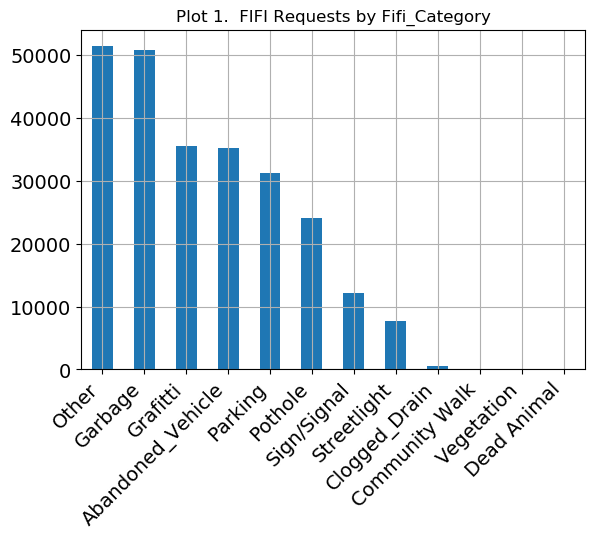

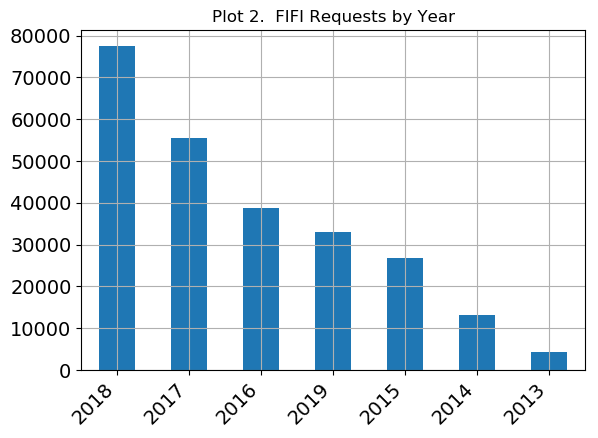

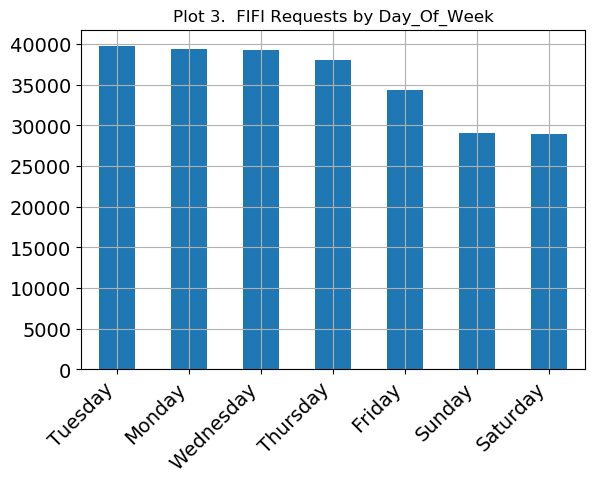

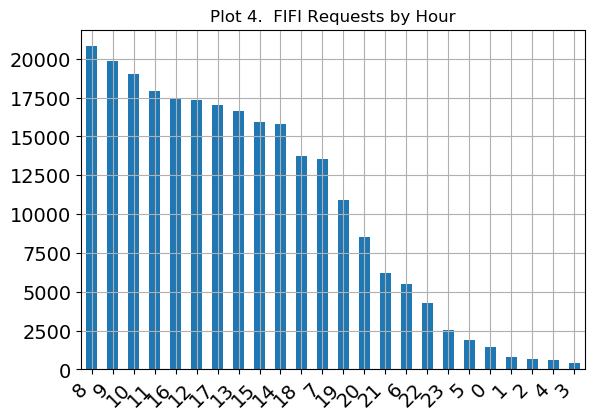

In [5]:
# plot FIFI requests by a few features of interest
features = ["FIFI_category", "year", "day_of_week", "hour"]

for num, feature in enumerate(features):
    fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5), dpi=100);
    df[feature].value_counts().plot(kind='bar');
    plt.title('Plot {}.  FIFI Requests by {}'.format(num+1, feature.title()));
    plt.xticks(rotation=45, ha='right', size=14);
    plt.yticks(size=14);
    plt.grid(True);
    plt.show();
    

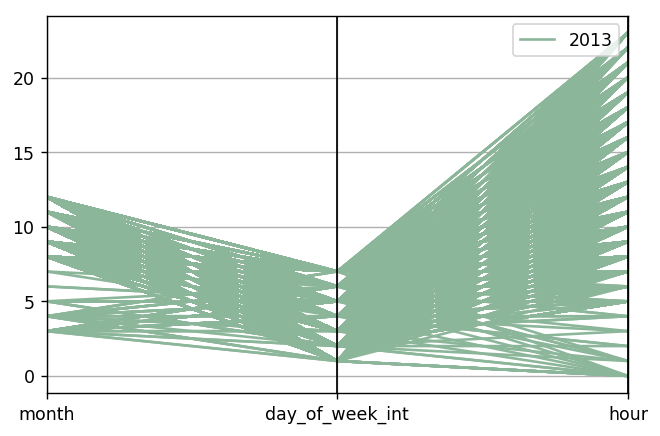

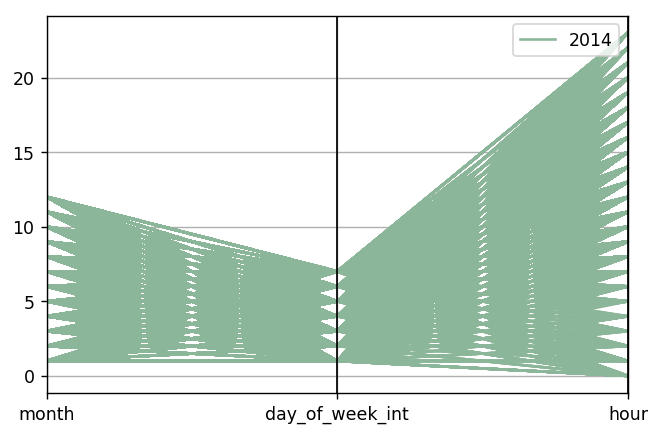

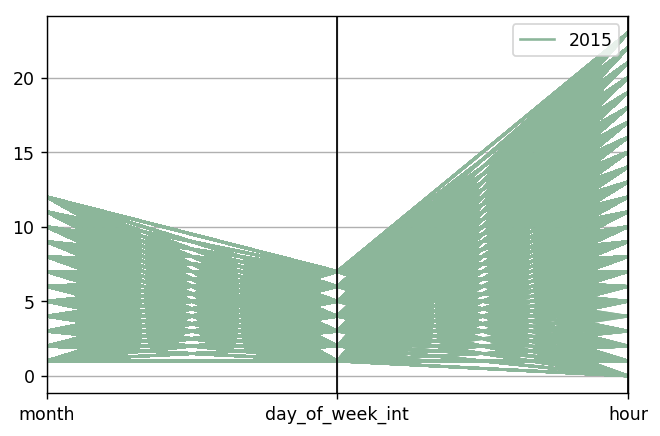

In [ ]:
"""
NOTE: with about 250,000 rows, this cell takes several minutes to run,
so you might just want to look at the output to look at the distribution of
when people submitted reports over the years. The parallel coordinate plots
compare the months, day of the week and time of day. Because 2013 and 2019 are
not full years, those plots will look a little different.
"""

from pandas.plotting import parallel_coordinates

conditions = [
    df["day_of_week"] == "Sunday",
    df["day_of_week"] == "Monday",
    df["day_of_week"] == "Tuesday",
    df["day_of_week"] == "Wednesday",
    df["day_of_week"] == "Thursday",
    df["day_of_week"] == "Friday",
    df["day_of_week"] == "Saturday"
]
outputs = np.arange(1, 8, step=1, dtype=np.int8)

res = np.select(conditions, outputs, np.nan)
df["day_of_week_int"] = pd.Series(res, dtype=np.int8)

df_ = df[["year", "month", "day_of_week_int", "hour"]]
    
    
for yr in df["year"].unique():
    plt.figure(figsize=(6, 4), dpi=125);
    parallel_coordinates(df_[df_["year"] == yr], "year");
    plt.show();

## Report Locations

The next several cells look at where reports were submitted.

In [7]:
lat_lst, long_lst = [], []
for row in df["Location_Details"]:
    try:
        lat, long = (str(row).split("LatLng: ")[1]).split(", ")
        lat_lst.append(lat)
        long_lst.append(long)
    except IndexError:
        lat_lst.append(np.nan)
        long_lst.append(np.nan)

df["latitude"], df["longitude"] = lat_lst, long_lst

total_unk_latitude = df["latitude"].isnull().sum()
print("missing {:,} latitude values and {:,} longitude values".format(total_unk_latitude,
                                                                    df["longitude"].isnull().sum()))
print("So, only {0:.2f}% of data points lack latitude and longitude.\n".format(100*total_unk_latitude/df.shape[0]))

df_fifi_unique = df.drop_duplicates(subset=["latitude",
                                            "longitude"], keep='first')
# drop rows with at least 2 null values:
df_fifi_unique.dropna(axis=0, thresh=2, inplace=True)
print("df_fifi_unique:", df_fifi_unique.shape)

# there are a lot of reports from the same locations
duplicateRowsDF = df[df.duplicated(["latitude", "longitude"])]
total_duplicate_locations = len(duplicateRowsDF)
print("\n\033[1mtotal_duplicate_locations: {:,}\033[0m\n".format(total_duplicate_locations))

print("\033[1mTop 10 most common reporting locations overall\033[0m:")
duplicateRowsDF.groupby(["latitude", "longitude"], axis=0).size().sort_values(ascending=False).nlargest(10)

print("\n\033[1mTop 10 category reports at a single location in a single year\033[0m:")
df[["year", "Location_Details", "latitude", "longitude",
    "FIFI_category"]].groupby(["year", "FIFI_category", "latitude",
                               "longitude"]).size().sort_values(ascending=False).nlargest(10)

missing 1,659 latitude values and 1,659 longitude values
So, only 0.67% of data points lack latitude and longitude.

df_fifi_unique: (239524, 46)

total_duplicate_locations: 9,291

Top 10 most common reporting locations overall:

Top 10 category reports at a single location in a single year:


year  FIFI_category      latitude            longitude          
2016  Parking            47.64715299998341   -122.383729            56
2018  Other              47.61599999998329   -122.335               28
2015  Other              47.61599999998332   -122.335               26
2018  Garbage            47.61599999998332   -122.335               22
2017  Other              47.61599999998329   -122.335               18
2018  Garbage            47.61599999998329   -122.335               18
2015  Grafitti           47.61599999998332   -122.335               17
2019  Garbage            47.62061399998334   -122.319173            16
2018  Other              47.61599999998332   -122.335               15
2017  Abandoned_Vehicle  47.633267399983374  -122.37541399999998    14
dtype: int64

Looking at the data overall in the cell above, __4 of the 5 most common reporting location are next to the Amazon headquarters__ on 9th Ave. and near the Seattle Police Department's downtown precinct. Most FIFI reports in the Amazon vacinity are about garbage, parking, or are classified as other.   

The map below shows the most common reporting location: 184 reports at (47.61599999998332, -122.335):  

![map](images/common_report_location.png)  

Of course, during the work day this part of downtown is likely the most densely populated part of the city, so we expect to see a greater number of reports. It would be nice if we could normalize our data according to the size of the local population. As usual, we could benefit from additional data.  

Using QGIS and shapefiles from the City of Seattle, I labeled each location's neighborhood, the neighborhood size, the U.S. Census blockgroup, and a variety of other demographic information. That enhanced dataset CSV file is about 500 MB, well above GitHub's maximum file size. But I plan to make an abridged version available. In the meantime, see the text file `top_neighborhoods_per_yr.txt` for the top reporting neighborhoods for each year, 2013-2019.  

In [9]:
# top 10 reporting locations by year
for yr in list(df["year"].unique()):
    print("\nTop 10 reporting locations in", yr)
    df_ = df[df["year"] == yr]
    print(df_[["Location_Details", "latitude", "longitude", 
               "FIFI_category"]].groupby(["FIFI_category", "latitude",
                                          "longitude"]).size().sort_values(ascending=False).nlargest(10))


Top 10 reporting locations in 2013
FIFI_category  latitude           longitude         
Grafitti       47.67415266483972  -122.3457887306285    5
Other          47.65843893714413  -122.3152221168543    4
               47.55329211712587  -122.2702505161262    4
Grafitti       47.66025652365234  -122.314128955667     4
               47.67422424635127  -122.3471320707362    3
               47.664111          -122.311662           3
Parking        47.61526497551018  -122.3228237406558    3
Grafitti       47.66844232571094  -122.2851233651138    3
Pothole        47.57744431965759  -122.3333441187836    3
Grafitti       47.65400033348237  -122.3140841448964    3
dtype: int64

Top 10 reporting locations in 2014
FIFI_category  latitude           longitude          
Grafitti       47.528614          -122.367875            6
               47.538658          -122.378433            5
               47.539327          -122.29417000000001    4
               47.522343          -122.35801       

In [10]:
# top reporting neighborhoods 
with open("data/top_neighborhoods_per_yr.txt", "r") as file:
    d = file.read()
d.split("\n")

['{2013: neighborhood_name    fifi_category',
 'Delridge             Grafitti         196',
 'Capitol Hill         Grafitti         180',
 '                     Other            159',
 'University District  Grafitti         136',
 'Ravenna              Grafitti         106',
 'Broadway             Other            102',
 '                     Grafitti          91',
 'Central District     Grafitti          87',
 '                     Other             86',
 'Capitol Hill         Pothole           68',
 'dtype: int64, 2014: neighborhood_name  fifi_category',
 'Rainier Valley     Grafitti         362',
 'Capitol Hill       Other            340',
 'Ballard            Abnd_Vehicle     297',
 'Capitol Hill       Pothole          290',
 'Rainier Valley     Other            262',
 'Central District   Grafitti         242',
 'Roosevelt          Grafitti         223',
 'Mount Baker        Grafitti         221',
 'Broadway           Other            209',
 'West Woodland      Abnd_Vehicle     201

In [ ]:
# run if you want to keep a CSV copy of the df
df_fifi_unique.to_csv("data/fifi_data.csv", index=False)